In [1]:
from netCDF4 import Dataset
import numpy as np
from pymbar import bar
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline

# TIP3P Calibration in brief

 Reading in the self adjusted mixture sampling simulation data.

In [2]:
DIR = "../sams/tip3p/"
files = ['out1.nc', 'out2.nc', 'out3.nc']

volume = []
sams_estimate = []
nwats = []
nsalt = []
proposal = []
protocol_work = []
for file in files:
    ncfile = Dataset(DIR + file,'r')
    volume.append(ncfile.groups['Sample state data']['volume'][:])
    sams_estimate.append(ncfile.groups['Sample state data']['sams bias'][-1,:])
    proposal.append(ncfile.groups['Sample state data']['proposal'][:][:,0,:])
    nspecies = ncfile.groups['Sample state data']['species counts']
    protocol_work.append(ncfile.groups['Sample state data']['cumulative work'][:,0,-1])
    nwats.append(nspecies[:,0])
    nsalt.append(nspecies[:,1])
    ncfile.close()

volume = np.hstack(([],*volume))
nwats = np.hstack(([],*nwats))
nsalt = np.hstack(([],*nsalt))
protocol_work =  np.hstack(([],*protocol_work))
proposal = np.vstack(proposal)

In [3]:
import calibration_tools as tools
from saltswap.wrappers import Salinator

## Comparing the relative free energy to add salt using BAR and SAMS

In [4]:
# Looking at the proposed insertions and deletions and extracting the corresponding work
max_nsalt = int(np.max(nsalt))
relative_free_energy = np.zeros(max_nsalt)
error = np.zeros(max_nsalt)
for i in range(max_nsalt):
    f, e = tools.calc_relative_free_energy(i, i+1, max_waters=np.max(nwats), proposals=proposal, work=protocol_work)
    relative_free_energy[i] = f
    error[i] = e

Plotting the BAR and SAMS results. SAMS calculates the cumulative free energy to add salt, so taking the relative difference to compare with BAR.

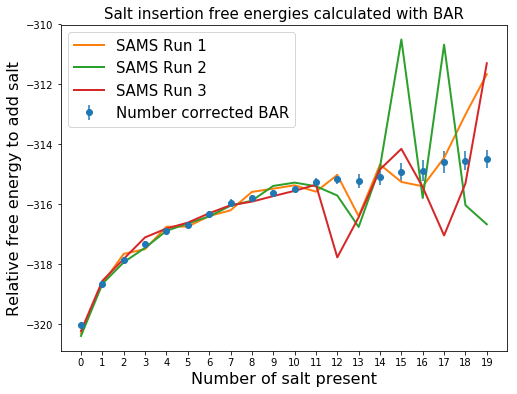

In [5]:
plt.figure(figsize=[8,6])
plt.errorbar(range(max_nsalt), relative_free_energy, yerr=error*2, label='Number corrected BAR', fmt='o')
for i in range(len(files)):
    plt.plot(-np.diff(sams_estimate[i]), label='SAMS Run {}'.format(i + 1), lw=2)

plt.xticks(range(0,20,1))
plt.title('Salt insertion free energies calculated with BAR', fontsize=15)
plt.xlabel('Number of salt present', fontsize=16)
plt.ylabel('Relative free energy to add salt', fontsize=16)
plt.legend(fontsize=15)
plt.show()

## Viewing how the average volume of the system varies with salt present

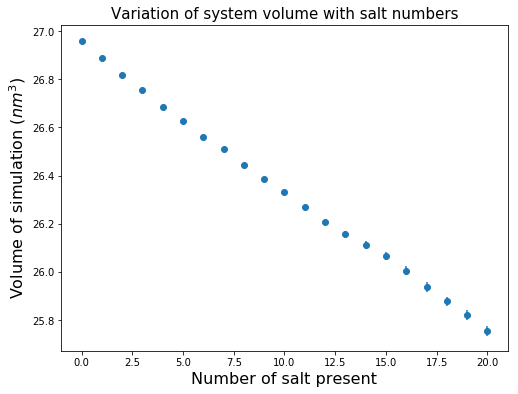

In [6]:
# Calculate the volume as a function of salt present
average_volume, error_volume = tools.calc_volume(volume, nsalt)

plt.figure(figsize=[8,6])
x = np.arange(np.max(nsalt)+1)
plt.errorbar(x, average_volume, yerr=error_volume*2, fmt='o')
plt.title('Variation of system volume with salt numbers', fontsize=15)
plt.xlabel('Number of salt present', fontsize=16)
plt.ylabel('Volume of simulation ($nm^3$)', fontsize=16)
plt.show()

## Predicting salt concentration as a function of the applied chemical potential
Estimating the uncertainty using bootstrap sampling of the BAR error estimate and assuming the BAR estimate is normally distributed. For now, it is assumed that the variation in volume is insignificant.

In [7]:
# The chemical potentials
mu = np.linspace(314.5,322, 100)

# The cumulative free energy to add salt
fn = np.hstack((0.0,np.cumsum(relative_free_energy)))

# Predict the cocentrations
nbootstraps = 500
predicted_concentration = np.zeros(len(mu))
predicted_ensemble = np.zeros((len(mu),nbootstraps))

for i in range(len(mu)):
    predicted_concentration[i] = Salinator.predict_concentration(mu[i], fn, average_volume)
    predicted_ensemble[i,:] = tools.predict_ensemble_concentration(mu[i], nsamples=nbootstraps, volume=average_volume, std_volume=error_volume, relative_free_energy=relative_free_energy, std_free=error)    

Plotting the salt titration curve:

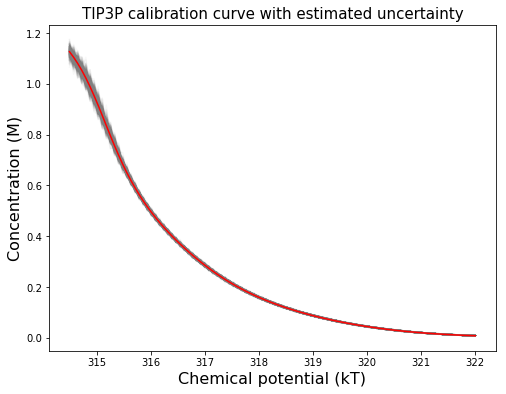

In [8]:
plt.figure(figsize=[8,6])
plt.plot(mu, predicted_ensemble, color='grey',alpha=0.05)
plt.plot(mu, predicted_concentration, color='red')
plt.xlabel('Chemical potential (kT)', fontsize=16)
plt.ylabel('Concentration (M)', fontsize=16)
plt.title('TIP3P calibration curve with estimated uncertainty', fontsize=15)
plt.show()

Note how the truncation of the calibration at `nsalt=20` results in a tailing off of the curve at lower values of the chemical potential. 

Quantifying the relative uncertainty in the predicted salt concentration with the coefficient of variation.

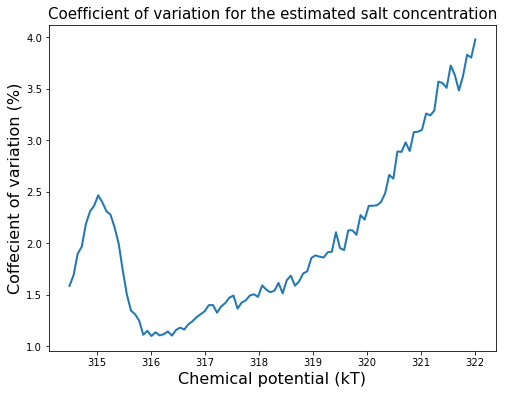

In [9]:
plt.figure(figsize=[8,6])
plt.plot(mu, 100.0*predicted_ensemble.std(axis=1)/predicted_concentration, lw=2)
plt.title('Coefficient of variation for the estimated salt concentration', fontsize=15)
plt.ylabel('Coffecient of variation (%)', fontsize=16)
plt.xlabel('Chemical potential (kT)', fontsize=16)
plt.show()

### Select new chemical potentials to validate the above titration curves
Which chemical potentials should one use to relicate specified concentrations?

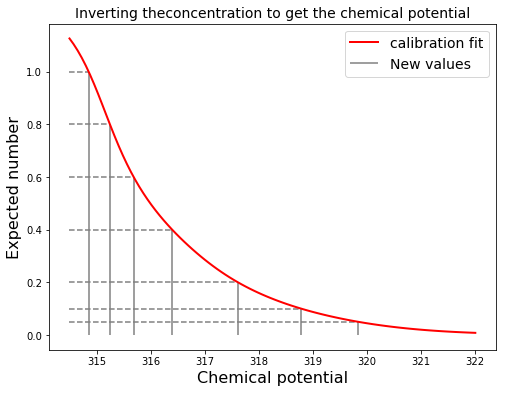

Required chemical potentials= [ 314.85447789  315.24721496  315.68584676  316.39766069  317.61299051
  318.78225386  319.83615121]


In [10]:
# Picking the concentrations we want to observe (in M):
desired_conentration = np.array([1.0, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05])

# Inverting the above titration curve to get the chemical potentials that correspond to the above concentrations
required_mu = np.zeros(len(desired_conentration))
for i in range(len(desired_conentration)):
    required_mu[i] = Salinator.invert_concentration(float(desired_conentration[i]), fn, average_volume)

plt.figure(figsize=[8,6])
#mu = np.linspace(310,322, 100)
plt.plot(mu, predicted_concentration, color='red', label='calibration fit', lw=2)
for i in range(len(required_mu)):
    if required_mu[i] == required_mu[-1]:
        plt.vlines(required_mu[i], ymin=0, ymax=desired_conentration[i], linestyle='-', color='grey', label='New values')
    else:
        plt.vlines(required_mu[i], ymin=0, ymax=desired_conentration[i], linestyle='-', color='grey')
    plt.hlines(desired_conentration[i], xmin=mu[0], xmax=required_mu[i], linestyle='--', color='grey')
        
plt.legend(fontsize=14)
plt.title('Inverting theconcentration to get the chemical potential', fontsize=14)
plt.xlabel('Chemical potential', fontsize=16)
plt.ylabel('Expected number', fontsize=16)
plt.show()

print('Required chemical potentials=',required_mu)